In [3]:
import scipy.special
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload 
%autoreload 1

In [4]:
from Corrfunc.utils import check_runtime_env

In [5]:
import os.path
import numpy as np
import pandas as pd
# parser.add_argument('boxsize') #L
# parser.add_argument('bin_file')
# parser.add_argument('mock_file1')
# parser.add_argument('mock_file2')
# parser.add_argument('output_file')
# parser.add_argument('--siglnMc') #scatter between intrinsic 
# parser.add_argument('--nc') #cluster number density
# parser.add_argument('--zphot') #photo-z
# parser.add_argument('--Qsel') #assembly bias term 
# parser.add_argument('--delg') #R_delta
# parser.add_argument('--downsample_flag')

In [6]:
check_runtime_env()

/global/homes/z/zchusre/.conda/envs/desdesi/lib/python3.8/site-packages/Corrfunc/utils.py:1071: UserWarning: Warning: Cray hugepages has a bug that may crash Corrfunc. You might be able to fix such a crash with `module unload craype-hugepages2M` (see https://github.com/manodeep/Corrfunc/issues/245 for details)
  warnings.warn('Warning: Cray hugepages has a bug that may crash '


<ipython-input-7-761f299786ce>:2: RuntimeWarning: divide by zero encountered in log
  return 0.5*(1+scipy.special.erf(np.log(M)/0.6))


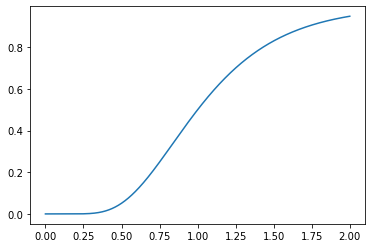

In [7]:
def N_cen(M):
    return 0.5*(1+scipy.special.erf(np.log(M)/0.6))

x = np.linspace(0,2,1000)
y = N_cen(x)

plt.plot(x,y)

The mean satellite number is defined by 
$<N_{sat}(M)> = <N_{cen}(M)> (\frac{M-M_0}{M_1})^{\alpha}$

which has a power-law shape. 

# Calculate Observed Halo Mass 

From Salcedo et al. 2020. 
The cluster-mass observable relation is a linear relation with a constant lognormal scatter:

$\ln M_{obs} = \ln M_c + \sigma_{\ln M_c} X $

The minimal mass for a halo to host a central is $\log M_{min} = \log M_{min,0} + Q_{env}(R_{\delta} - 0.5)$, in which $Q_{env}$ is the environmental dependence of galaxy occupation parameter. $R_\delta$ is the rank of halo environmental density measured with top-hat spheres of radius $8 h^{-1} \text{Mpc}$

# Halo occupation model

The occupation number of the halos is parametrized by 

$<N_{cen}(M)> = \frac{1}{2} [1+\text{erf} (\frac{\log M - \log M_{min}} {\sigma_{\log M}})] $

whose shape can be plotted as the following

# Calculate $\xi$

In [8]:
project_path = "/global/cfs/cdirs/des/zhou/spt_lensing/"
particle_rel_path = "abacus/memHOD_11.2_12.4_0.65_1.0_0.2_0.0_0_z0p3.hdf5"
halo_rel_path = "data/halos_spt_xi_5.hdf5"
output_rel_path =  "data/testoutput"
bin_rel_path = "bin_file.txt"

In [9]:
particle_path = os.path.join(project_path, particle_rel_path)
halo_path = os.path.join(project_path,halo_rel_path)
output_path = os.path.join(project_path,output_rel_path)
bin_path = os.path.join(project_path,bin_rel_path)

In [10]:
boxsize = 1100
rmin = 0.05
rmax = 125
nbins=50
bins = np.logspace(np.log10(rmin), np.log10(rmax), nbins + 1)
binfile=bin_path
mock_file1 = halo_path
mock_file2 = particle_path
output_file = output_path
siglnMc = 0.4
nc = 3.228E-6
Qsel = 0
nthreads = 4
zphot = False

In [11]:
import h5py as h5
import os.path
import numpy as np
import math
import Corrfunc
from Corrfunc._countpairs import countpairs

In [12]:
f = open(bin_path,"w")
for i in range(len(bins)-1):
    f.write("{:.2f} {:.2f}\n".format(bins[i],bins[i+1]))
f.close()

In [13]:
a_file = open(bin_path,'r')
file_contents = a_file.read()
print(file_contents)

0.05 0.06
0.06 0.07
0.07 0.08
0.08 0.09
0.09 0.11
0.11 0.13
0.13 0.15
0.15 0.17
0.17 0.20
0.20 0.24
0.24 0.28
0.28 0.33
0.33 0.38
0.38 0.45
0.45 0.52
0.52 0.61
0.61 0.71
0.71 0.84
0.84 0.98
0.98 1.14
1.14 1.34
1.34 1.56
1.56 1.83
1.83 2.14
2.14 2.50
2.50 2.92
2.92 3.42
3.42 4.00
4.00 4.67
4.67 5.47
5.47 6.39
6.39 7.48
7.48 8.74
8.74 10.22
10.22 11.95
11.95 13.98
13.98 16.35
16.35 19.12
19.12 22.35
22.35 26.14
26.14 30.57
30.57 35.75
35.75 41.80
41.80 48.88
48.88 57.16
57.16 66.85
66.85 78.17
78.17 91.41
91.41 106.89
106.89 125.00



In [14]:
f = h5.File(halo_path, 'r')
print (type(f.keys()))
print(type((f)))
print(type(f['halos']))

<class 'h5py._hl.base.KeysViewHDF5'>
<class 'h5py._hl.files.File'>
<class 'h5py._hl.dataset.Dataset'>


In [15]:
f.close()

In [16]:
import Corrfunc
from Corrfunc.theory.DD import DD

In [30]:
def writeXi(boxsize,bin_file,mock_file1,mock_file2,output_file,siglnMc,nc,Qsel,nthreads):
    Ncluster = math.floor( (boxsize**3.0) * float(nc) ) #number of cluster
    infile = h5.File(mock_file1, 'r')
    halos = infile['halos']
    halos = halos[halos['M200b'] > 0] #halo mass that passes M_min
    Nh = int(len(halos)) #number of halos
    infile.close()
    np.random.seed(0)
    randnorms = np.random.normal(0.0, 1.0, Nh)
    # percentiles = h5.File(str(args.delg), 'r')['halos']['percentile'] #Delta_gamma
    halos['Mobs'] = np.exp( np.log(halos['M200b']) + float(siglnMc) * randnorms )
                           # + float(args.Qsel) * (percentiles - 0.5))
    halos.sort(order="Mobs")
    mock1 = halos[-Ncluster:] #only choose most massive clusters
    dummy2 = h5.File(str(mock_file2), 'r')
    mock2 = dummy2['particles']
    
    N1 = len(mock1)
    N2 = len(mock2)

    x1 = mock1['pos_x'].astype(np.float32)
    y1 = mock1['pos_y'].astype(np.float32)

    x2 = mock2['x'].astype(np.float32)
    y2 = mock2['y'].astype(np.float32)

    if zphot:
      z1 = mock1['zphot'].astype(np.float32)
      z2 = mock2['zphot'].astype(np.float32)
    else:
      z1 = mock1['pos_z'].astype(np.float32)
      z2 = mock2['z'].astype(np.float32)
        
    # input_array = [x1,y1,z1,x2,y2,z2]
    
#     for item in input_array:
#         print(item, len(item))
    
#     print(bin_file)
    
#     a_file = open(bin_path,'r')
#     file_contents = a_file.read()
#     print(file_contents)
    
    
    
    results_DD = DD(1,1, binfile, X1=x1, Y1=y1, Z1=z1, X2=x2, Y2=y2, Z2=z2,verbose=True, periodic=False)
    for r in results_DD: print("{0:10.6f} {1:10.6f} {2:10.6f} {3:10d} {4:10.6f}".format(r['rmin'], r['rmax'], r['ravg'],r['npairs'], r['weightavg'])) # doctest: +NORMALIZE_WHITESPACE

    print(N1, N2, boxsize)
    for i in range(0, len(results_DD)):
        RR = N1*N2*(4.0/3.0)*np.pi*(results_DD[i][1]**3.0 - results_DD[i][0]**3.0) / boxsize**3.0
        print("The value of RR is ", RR)
        results_DD[i][3] = results_DD[i][3] + ((results_DD[i][3]/RR - 1.0),)
     
    for r in results_DD: print("{0:10.6f} {1:10.6f} {2:10.6f} {3:10d} {4:10.6f}".format(r['rmin'], r['rmax'], r['ravg'],r['npairs'], r['weightavg'])) # doctest: +NORMALIZE_WHITESPACE
    return(results_DD)

In [31]:
results_DD = writeXi(boxsize,bin_path,mock_file1,mock_file2,output_file,siglnMc,nc,Qsel,nthreads)

In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 17,17,8.  Time taken =   0.000 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.013 secs


  0.050000   0.060000   0.000000          0   0.000000
  0.060000   0.070000   0.000000          4   0.000000
  0.070000   0.080000   0.000000          2   0.000000
  0.080000   0.090000   0.000000          2   0.000000
  0.090000   0.110000   0.000000          6   0.000000
  0.110000   0.130000   0.000000          2   0.000000
  0.130000   0.150000   0.000000          6   0.000000
  0.150000   0.170000   0.000000          4   0.000000
  0.170000   0.200000   0.000000         14   0.000000
  0.200000   0.240000   0.000000         24   0.000000
  0.240000   0.280000   0.000000         10   0.000000
  0.280000   0.330000   0.000000         24   0.000000
  0.330000   0.380000   0.000000         18   0.000000
  0.380000   0.450000   0.000000         28   0.000000
  0.450000   0.520000   0.000000         32   0.000000
  0.520000   0.610000   0.000000         48   0.000000
  0.610000   0.710000   0.000000         32   0.000000
  0.710000   0.840000   0.000000         44   0.000000
  0.840000

In [27]:
output_txt = "data/result_DD.txt"

In [29]:
outfile = open(os.path.join(project_path,output_txt), 'w')

outfile.write("# rmin rmax xi\n")

for bin in results_DD:
  outfile.write(str(bin[0])+" "+str(bin[1])+" "+str(bin[3])+"\n") 

outfile.close()

In [19]:
results_path = os.path.join(project_path,"data/results.npz")
np.savez(results_path,results_DD)

In [23]:
help(countpairs)

Help on built-in function countpairs in module Corrfunc._countpairs:

countpairs(...)
    countpairs(autocorr, nthreads, binfile, X1, Y1, Z1, weights1=None, weight_type=None, periodic=True,
               X2=None, Y2=None, Z2=None, weights2=None, verbose=False, boxsize=0.0,
               output_ravg=False, xbin_refine_factor=2, ybin_refine_factor=2,
               zbin_refine_factor=1, max_cells_per_dim=100, copy_particles=True,
               enable_min_sep_opt=True, c_api_timer=False, isa=-1)
    
    Calculate the 3-D pair-counts, ξ(r), auto/cross-correlation 
    function given two sets of points represented by X1/Y1/Z1 and X2/Y2/Z2 
    arrays.
    
    Note, that this module only returns pair counts and not the actual 
    correlation function ξ(r). See the mocks/wtheta/wtheta.c for 
    computing ξ(r) from the output of DD(r). Also note that the 
    python wrapper for this extension: `Corrfunc.theory.DD` is more user-friendly.
    
    If you see unrendered characters, then yo